  n  theta cov_g_a cov_g_b cov_g_c     B
  6 2.7027  0.8049  0.9887  0.8323 10000
 10 2.7027  0.8369  0.9891  0.8561 10000
 20 2.7027  0.8891  0.9881  0.8990 10000
 30 2.7027  0.9062  0.9822  0.9150 10000
 50 2.7027  0.9194  0.9721  0.9244 10000


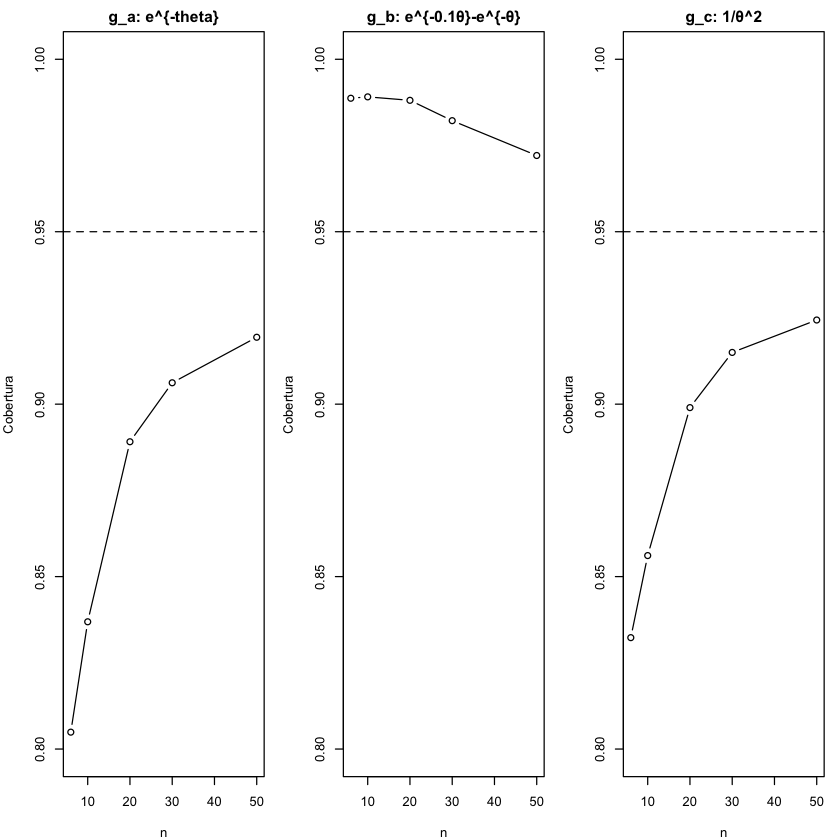

In [1]:
## Monte Carlo de cobertura para ICs (delta) – Exponencial(rate = theta)
## g_a(theta) = exp(-theta)
## g_b(theta) = exp(-0.1*theta) - exp(-theta)
## g_c(theta) = 1/theta^2

set.seed(123)

## ---- parâmetros do experimento (ajuste à vontade) ----
theta0 <- 2.7027                 # use o que quiser; ex: o seu theta_MV dos dados
ns     <- c(6, 10, 20, 30, 50)   # tamanhos amostrais a testar
B      <- 10000                  # número de réplicas por (n, g)

## ---- funções g e derivadas ----
g_a      <- function(th)  exp(-th)
g_b      <- function(th)  exp(-0.1*th) - exp(-th)
g_c      <- function(th)  1/(th^2)

g_a_d    <- function(th) -exp(-th)                  # derivada de g_a
g_b_d    <- function(th) -0.1*exp(-0.1*th) + exp(-th)
g_c_d    <- function(th) -2/(th^3)

## variância assintótica de theta_hat: Var(theta_hat) ~ theta^2 / n
## (Fisher info para Exponencial com taxa theta: I(theta)=n/theta^2)
var_theta_hat <- function(th, n) th^2 / n

## constrói IC delta para g, com truncagem opcional ao espaço natural
ci_delta <- function(g_hat, g_deriv_hat, var_th_hat,
                     alpha = 0.05, lower_trunc = -Inf, upper_trunc = Inf) {
  se2 <- (g_deriv_hat^2) * var_th_hat
  se  <- sqrt(se2)
  z   <- qnorm(1 - alpha/2)
  lo  <- g_hat - z * se
  hi  <- g_hat + z * se
  c(max(lo, lower_trunc), min(hi, upper_trunc))
}

## ---- motor de simulação para um n específico ----
sim_cobertura_n <- function(n, theta, B) {
  cover_a <- cover_b <- cover_c <- 0L

  for (b in seq_len(B)) {
    z <- rexp(n, rate = theta)             # Z_i ~ Exp(theta)
    th_hat <- n / sum(z)                   # MLE: n / sum(Z_i)

    ## plug-in para g
    ghat_a <- g_a(th_hat)
    ghat_b <- g_b(th_hat)
    ghat_c <- g_c(th_hat)

    ## derivadas em th_hat
    g_a_d_hat <- g_a_d(th_hat)
    g_b_d_hat <- g_b_d(th_hat)
    g_c_d_hat <- g_c_d(th_hat)

    ## Var(theta_hat) ~ theta_hat^2 / n   (plug-in)
    var_th_hat <- var_theta_hat(th_hat, n)

    ## CIs (delta). Truncagem: [0,1] para probabilidades; [0, +inf) para variância.
    ci_a <- ci_delta(ghat_a, g_a_d_hat, var_th_hat, lower_trunc = 0, upper_trunc = 1)
    ci_b <- ci_delta(ghat_b, g_b_d_hat, var_th_hat, lower_trunc = 0, upper_trunc = 1)
    ci_c <- ci_delta(ghat_c, g_c_d_hat, var_th_hat, lower_trunc = 0, upper_trunc = Inf)

    ## verdadeiros g(theta)
    ga_true <- g_a(theta)
    gb_true <- g_b(theta)
    gc_true <- g_c(theta)

    ## cobertura
    cover_a <- cover_a + as.integer(ga_true >= ci_a[1] && ga_true <= ci_a[2])
    cover_b <- cover_b + as.integer(gb_true >= ci_b[1] && gb_true <= ci_b[2])
    cover_c <- cover_c + as.integer(gc_true >= ci_c[1] && gc_true <= ci_c[2])
  }

  data.frame(
    n         = n,
    theta     = theta,
    cov_g_a   = cover_a / B,
    cov_g_b   = cover_b / B,
    cov_g_c   = cover_c / B,
    B         = B
  )
}

## ---- roda para todos os n ----
res <- do.call(rbind, lapply(ns, sim_cobertura_n, theta = theta0, B = B))
print(res, row.names = FALSE)

## ---- (opcional) visualização rápida ----
if (requireNamespace("graphics", quietly = TRUE)) {
  op <- par(mfrow = c(1,3), mar = c(4,4,2,1))
  plot(res$n, res$cov_g_a, type="b", ylim=c(0.8,1),
       xlab="n", ylab="Cobertura", main="g_a: e^{-theta}")
  abline(h = 0.95, lty = 2)
  plot(res$n, res$cov_g_b, type="b", ylim=c(0.8,1),
       xlab="n", ylab="Cobertura", main="g_b: e^{-0.1θ}-e^{-θ}")
  abline(h = 0.95, lty = 2)
  plot(res$n, res$cov_g_c, type="b", ylim=c(0.8,1),
       xlab="n", ylab="Cobertura", main="g_c: 1/θ^2")
  abline(h = 0.95, lty = 2)
  par(op)
}